Sam Deleu

Opdracht: Sessie 1: Neurale netwerken

# Deep learning -  Opdracht sessie 01 - neurale netwerken

## Doelstelling van de opdracht

Deep learning is onovertroffen in het extraheren van informatie uit grote hoeveelheden data. Als subdomein binnen de machine learning zorgt het ervoor dat praktische toepassingen die vroeger als sciencefiction werden beschouwd realiteit worden. Denk maar aan betere preventieve gezondheidszorg, self-driving cars, performante recommendation systems, CSI style beeldverwerking, machine translations, etc.

De onderliggende technologie van de verschillende deep learning architecturen zijn de zogenaamde neurale netwerken.
Het is daarom essentiëel een goed inzicht te verkrijgen in de mechanismen en parameters van deze neurale netwerken.

Bij deze opdracht zullen feedforward neurale netwerken in Keras worden gebouwd voor het uitvoeren van classificatietaken.

De warm-up oefening is vooral bedoeld om inzicht te verkrijgen in de invloed en rol van de verschillende hyperparameters. Deze oefening wordt stap voor stap opgebouwd. Belangrijk zijn niet zozeer de uiteindelijk accuracy cijfers, maar de conclusies en inzichten die in dit document worden neergeschreven.

Bij de andere oefeningen wordt van de student verwacht om zelfstandig een performante pipeline te kunnen opzetten van ruwe data tot en met een performante classificatie.


## Functions

### Imports

In [1]:
%matplotlib inline
from datetime import datetime
import pytz

# Graphics
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from termcolor import (
    colored,
    cprint,
)
import matplotlib.image as mpimg
from skimage.io import imread, imshow

# Data
import numpy as np
import pandas as pd

# SKLearn
from sklearn.datasets import (
    make_blobs,
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    OneHotEncoder,
    LabelBinarizer,
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
)

# distributions
from scipy.stats import randint 
from scipy.stats import uniform

# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras.models import (
    Sequential,
)

from tensorflow.keras.layers import (
    Activation,
    Input, Dense,
    Dropout,
    BatchNormalization,
    Conv2D, MaxPooling2D,
)

from tensorflow.keras.optimizers import (
    SGD,
    Adam,
    
)

from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
)

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

# Some defaults for matplotlib
LARGE = 12
MEDIUM = 10
SMALL = 6
plt.tight_layout()
plt.rcParams.update({
    'axes.titlesize': MEDIUM,
    'legend.fontsize': SMALL,
    'figure.figsize': (10, 5),
    'axes.labelsize': MEDIUM,
    'axes.titlesize': MEDIUM,
    'xtick.labelsize': SMALL,
    'ytick.labelsize': SMALL,
    'figure.titlesize': LARGE
})

# Reproducibility of the results
SEED = 42
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(SEED)

###### Voor Tensorflow-GPU ########
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

2025-03-12 07:42:31.899711: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 07:42:31.991586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741761752.024371 2572372 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741761752.036261 2572372 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 07:42:32.085475: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<Figure size 640x480 with 0 Axes>

### Display info

In [2]:
# Display Helpers
def display_title(title, value=None):
    if value is None:
        cprint(title, "black", "on_cyan")
    else:
        print(colored(title, "blue"))
        print(value)

def display_value(title, value):
    print(f"{colored(title, "blue")}: {value}")

display_title("Title")
display_title("Value", value=1)
display_value("Today is", datetime.now(pytz.timezone("Europe/Brussels")).strftime("%Y-%m-%d %H:%M:%S"))


Title
Value
1
Today is: 2025-03-12 07:42:40


### Plot history

In [3]:
# Plotting
def plot_history(history, title="Results"):
    """Plot error and accuracy of model.fit """
    fig, axes = plt.subplots(1, 2, figsize = (12, 3), sharey=False)

    # Loss (Training error)
    axes[0].set_title("Loss")
    axes[0].plot(history["loss"], "red", linewidth=2.0, label="training loss")
    axes[0].plot(history['val_loss'],'blue',linewidth=2.0, label="validation loss")
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('error')
    axes[0].grid()
    axes[0].legend(loc='upper right')
    
    # Accuracy
    axes[1].set_title("Accuracy")
    axes[1].plot(history["accuracy"], "red", linewidth=2.0, label="training accuracy")
    axes[1].plot(history['val_accuracy'],'blue',linewidth=2.0, label="validation accuracy")
    axes[1].set_xlabel('epoch')
    axes[1].set_ylabel('accuracy')
    axes[1].grid()
    axes[1].legend(loc="lower right")

    # Overall title
    fig.suptitle(title)

    # show
    plt.show()

### Metrics

In [4]:
# Metrics
def print_metrics(model, X_test, y_test, title="Results"):
    display_title(title)
    y_pred_proba = model.predict(X_test)
    y_pred_class = np.argmax(y_pred_proba, axis=1)

    display_title("classification report", classification_report(y_test, y_pred_class))
    display_title("confusion matrix", confusion_matrix(y_test, y_pred_class))
    display_value("Accuracy score", (accuracy_score(y_test, y_pred_class) * 100))

### Plot boundary

In [5]:
# Plot decision boundary
def plot_decision_boundary(model, X_orig, y_orig, title="Results"):
    # Plotten van de decision boundary

    # build a grid
    h = 0.2
    x1_min = X_orig[:,0].min()-2
    x1_max = X_orig[:,0].max()+2
    x2_min = X_orig[:,1].min()-2
    x2_max = X_orig[:,1].max()+2
    xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),np.arange(x2_min, x2_max, h))
    # big list of point coordinates for the grid
    xy = np.vstack([xx.ravel(), yy.ravel()]).T
    
    grid_predict_proba = model.predict(xy)
    grid_predict_class = np.argmax(grid_predict_proba, axis=1)
    # reshape to xx or yy
    reshaped_grid_predict_class = grid_predict_class.reshape(xx.shape)

    fig = plt.figure(figsize=(8, 4))
    # color plot of grid data
    plt.pcolormesh(xx, yy, reshaped_grid_predict_class, cmap='rainbow')
    
    # plot the original dataset again (make edges black)
    plt.scatter(X_orig[:, 0], X_orig[:, 1], c=y_orig, edgecolor='k', s=20, cmap='rainbow')
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.suptitle(title)
    plt.show()

## Warm-up

Hieronder worden 1000 random samples gegenereerd (getrokken uit vier Gaussiaanse verdelingen). De data bestaat uit 2 features en elke sample behoort tot één van de vier klasses.
Gebruik deze data om een neuraal netwerk te trainen dat als classifier optreedt.
De volledige datapipeline van deze opdracht is hieronder beschikbaar. De bedoeling is om de invloed van de hyperparameters uit te testen en de conclusies neer te schrijven in dit document. De vragen kan je onder de voorbeeldcode terugvinden.

### Data preparation

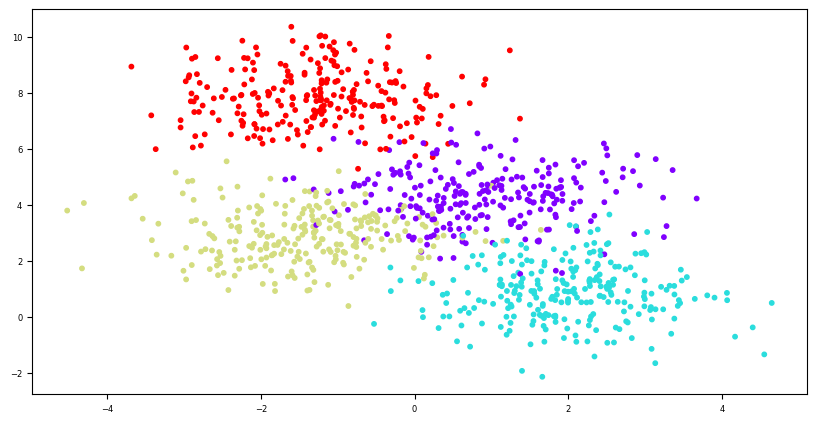

In [6]:
X, y = make_blobs(n_samples=1000, centers=4, center_box = (-10,10),
                  random_state=0, cluster_std=1)
plt.scatter(X[:, 0], X[:, 1], s=10, c=y, cmap="rainbow");

In [7]:
# splitsen in test set en training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =0)

# ---------------------------------------------------
# normaliseren van de input data

#scaler = StandardScaler()

#scaler.fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

#----------------------------------------------------
# one-hot encoding op output
y_train = to_categorical(y_train)
display(y_train)

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

### First example

In [8]:
# NN parameters

input_dim = X_train.shape[1]  # input layer size
batch_size = 32               # nbr of samples presented before adopting the weights
epochs = 100                  # nbr of times all data is presented

dropoutrate = 0.0             # neuron dropout on the different layers

activation_hidden = 'relu'    # activatiefunctie van de hidden layer neuronen
activation_output = 'softmax' # activatie van de output layer neuronen
initializer = 'RandomUniform' # type van kernel intializer

SGD = tf.keras.optimizers.SGD(learning_rate=0.3)  # gradient descend with momentum optimizer

# Model
model = Sequential()

# Input Layer
model.add(Input(shape=(input_dim,)))
          
# Layer 1
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))

# layer 2
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))

# Layer 3
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))

# Layer 4
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))

# Output Layer
model.add(Dense(y_train.shape[1], kernel_initializer=initializer,activation=activation_output))

display_title("Model 1")
display(model.summary())



I0000 00:00:1741761830.306511 2572372 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3574 MB memory:  -> device: 0, name: NVIDIA RTX A3000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model 1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            84 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,404 (5.48 KB)

 Trainable params: 1,404 (5.48 KB)

 Non-trainable params: 0 (0.00 B)

None

In [9]:
# Build the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)


In [10]:
# train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    validation_split = 0.2,  # use 20% of the training data used for validation
    verbose=1
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2781 - loss: 1.3863 - val_accuracy: 0.2812 - val_loss: 1.3860
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2790 - loss: 1.3857 - val_accuracy: 0.2812 - val_loss: 1.3852
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4437 - loss: 1.3836 - val_accuracy: 0.5188 - val_loss: 1.3779
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5629 - loss: 1.3693 - val_accuracy: 0.4563 - val_loss: 1.3244
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4761 - loss: 1.2864 - val_accuracy: 0.4563 - val_loss: 1.1289
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4722 - loss: 1.0985 - val_accuracy: 0.4563 - val_loss: 0.9589
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4991 - loss: 0.9420 - val_accuracy: 0.5437 - val_loss: 0.8467
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5914 - loss: 0.8379 - val_accuracy: 0.

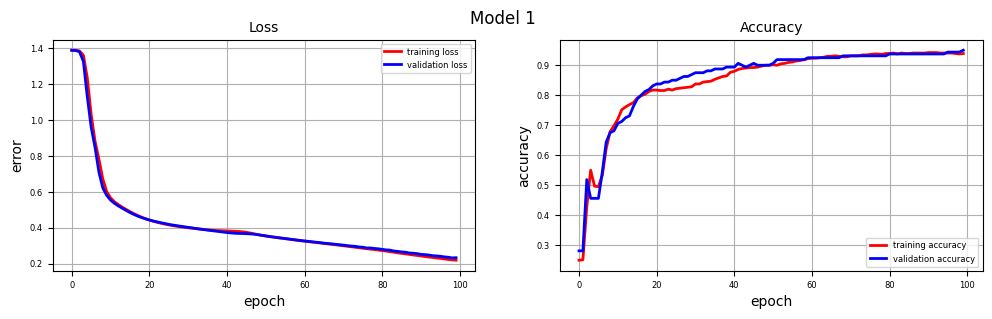

Model 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
classification report
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        44
           1       0.94      0.98      0.96        51
           2       0.86      0.88      0.87        48
           3       1.00      0.96      0.98        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.91      0.91      0.90       200

confusion matrix
[[34  3  7  0]
 [ 1 50  0  0]
 [ 6  0 42  0]
 [ 2  0  0 55]]
Accuracy score: 90.5
  1/172 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step

2025-03-12 07:45:42.010682: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


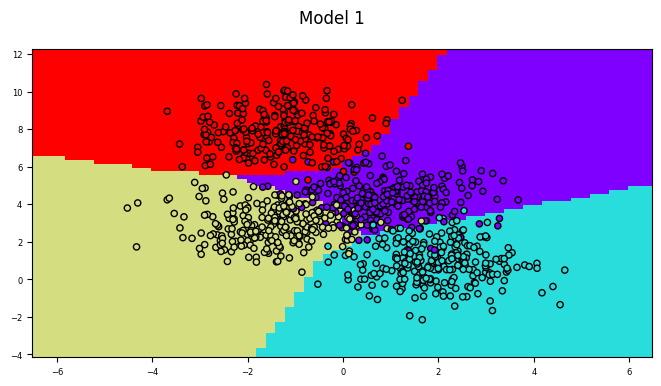

In [11]:
# Display Results
# History of training process
plot_history(history.history, title="Model 1")
# Metrics with test set
print_metrics(model, X_test, y_test, title="Model 1")

# Graphical represenation of resulting split
plot_decision_boundary(model, X, y, title="Model 1")

### Opdrachten warm-up oefening

1. Varieer bij SGD de learning rate en onderzoek wat er gebeurt wanneer deze te klein of te groot wordt. Wat is de invloed van normalisatie op de learning rate en de plot van de model loss?
2. Probeer verschillende optimizers uit: SGD, Adam, RMSProp, Adagrad, ... (https://keras.io/optimizers/). Kijk wat er gebeurt in termen van de model loss curve en de accuracy.
3. Kies een dropoutrate van 0.8. Verklaar wat er gebeurt. Zet nadien de dropout rate terug naar 0.0
4. Verhoog het aantal neuronen in de hidden layers. Wat is de invloed daarvan?
5. Verhoog het aantal hidden layers. Wat merk je? Bekijk de decision boundary. Controleer of je met overfitting te maken hebt. Verhoog nu de dropout rate. Verklaar wat er gebeurt.
6. Bespreek de invloed van batchnormalization.
7. Probeer verschillende activatiefuncties uit bij de hidden layers. (https://keras.io/activations/)
8. Probeer verschillende initializers. (https://keras.io/initializers/)
9. Doe hyperparameter tuning via grid search, random search en bayes optimization. Wat is de finale accuracy die je haalt op de test set?


#### Function with base NN layout

In [13]:
def nn_architecture_1(
    # NN layout parameters
    name,                              # descriptive name of the layout
    input_dimension,                   # input layer size
    output_dimension,                  # output layer size
    number_of_hidden_layers,           # Number of hidden "identical" layers
    hidden_layer_neurons,              # nbr of neurons in a hidden layer
    dropoutrate,                       # neuron dropout on the different layers
    activation_function_hidden_layer,  # activatiefunctie van de hidden layer neuronen
    activation_function_output_layer,  # activatie van de output layer neuronen
    kernel_initializer,                # type van kernel intializer
    optimizer,                         # optimizer to adjust weights
    batch_normalization = False,       # add batch normalization to each row
):
    """ Sequential Architecture with hidden layers of same size
        the loss function is fixed on categorical_crossentropy
        the metric used for evaluation is 'accuracy'
    """
    # Model
    model = Sequential()
    
    # Input Layer
    model.add(Input(shape=(input_dimension,)))
    if batch_normalization:
        model.add(BatchNormalization())

    # Hidden layers
    for _ in range(number_of_hidden_layers):
        model.add(Dense(hidden_layer_neurons,
                        kernel_initializer=kernel_initializer,
                        bias_initializer="zeros",
                        activation=activation_function_hidden_layer))
        if batch_normalization:
            model.add(BatchNormalization())
        model.add(Dropout(dropoutrate))
    
    # Output Layer
    model.add(Dense(output_dimension,
                    kernel_initializer=kernel_initializer,
                    activation=activation_function_output_layer))
    
    # display_title(name)
    # display(model.summary())

    # Build the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'],
    )

    return model


# Uitwerking van de opdrachten
## 1a. Variatie van de learning rate, zelfde layout

In [14]:
def deel_1_variatie_learning_rate(
    experiment = "EXP",
    learning_rate = 0.0001,
    momentum = 0.0,
    nesterov = False,
    batch_normalization = False,
):
    """ De functie maakt gebruik van de globale X, y, X_test, y_test waarden """
    experiment_name = f"{experiment} - A1 SGD LR({learning_rate}) Momentum({momentum}) Nesterov({nesterov}) Norm({batch_normalization})"
    nn_model = nn_architecture_1(
        # NN layout parameters
        name = experiment_name,
        input_dimension = X_train.shape[1],
        output_dimension = y_train.shape[1],
        number_of_hidden_layers = 4,
        hidden_layer_neurons = 20,
        dropoutrate = 0.0,
        activation_function_hidden_layer = "relu",
        activation_function_output_layer = "sigmoid",
        kernel_initializer = "RandomUniform",
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov),
        batch_normalization = batch_normalization,
    )
    
    # train the model
    history = nn_model.fit(
        X_train, y_train,
        epochs=100,
        validation_split = 0.2,  # use 20% of the training data used for validation
        verbose=0
    )
    
    # Display Results
    plot_history(history.history, title=experiment_name)
    print_metrics(nn_model, X_test, y_test, title=experiment_name)
    # plot_decision_boundary(nn_model, X, y, title=experiment_name)    

### Learning rate SGD optimizer

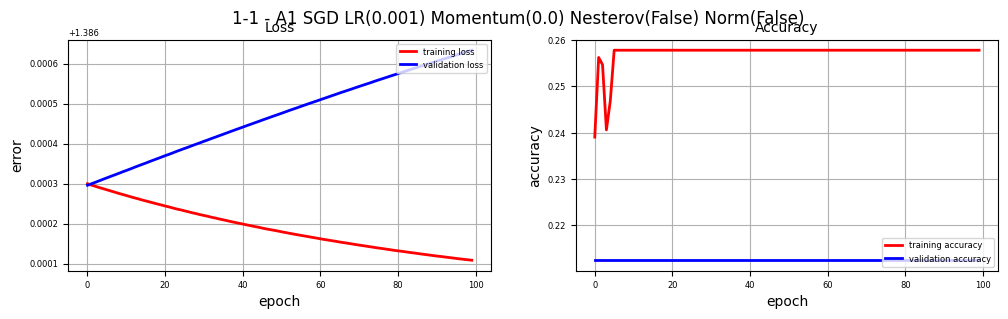

1-1 - A1 SGD LR(0.001) Momentum(0.0) Nesterov(False) Norm(False)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.26      1.00      0.41        51
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57

    accuracy                           0.26       200
   macro avg       0.06      0.25      0.10       200
weighted avg       0.07      0.26      0.10       200

confusion matrix
[[ 0 44  0  0]
 [ 0 51  0  0]
 [ 0 48  0  0]
 [ 0 57  0  0]]
Accuracy score: 25.5


2025-03-12 07:48:21.925740: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
/home/sam/howest/howest-dl/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

In [15]:
deel_1_variatie_learning_rate(experiment = "1-1", learning_rate = 0.001, momentum = 0.0, nesterov = False, batch_normalization = False)

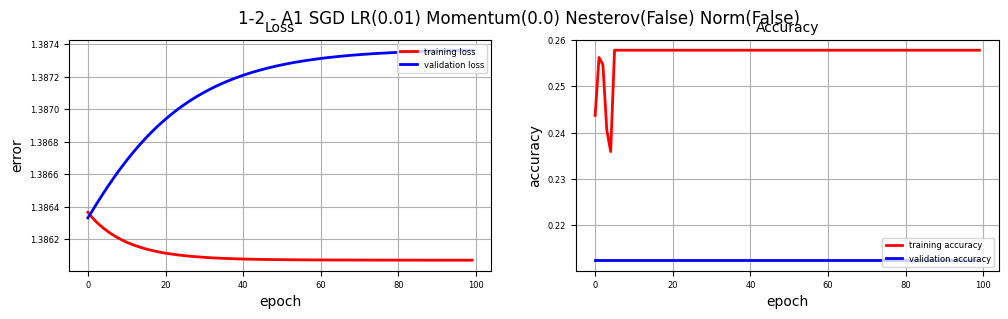

1-2 - A1 SGD LR(0.01) Momentum(0.0) Nesterov(False) Norm(False)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.26      1.00      0.41        51
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57

    accuracy                           0.26       200
   macro avg       0.06      0.25      0.10       200
weighted avg       0.07      0.26      0.10       200

confusion matrix
[[ 0 44  0  0]
 [ 0 51  0  0]
 [ 0 48  0  0]
 [ 0 57  0  0]]
Accuracy score: 25.5


2025-03-12 07:48:53.630898: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
/home/sam/howest/howest-dl/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

In [16]:
deel_1_variatie_learning_rate(experiment = "1-2", learning_rate = 0.01, momentum = 0.0, nesterov = False, batch_normalization = False)

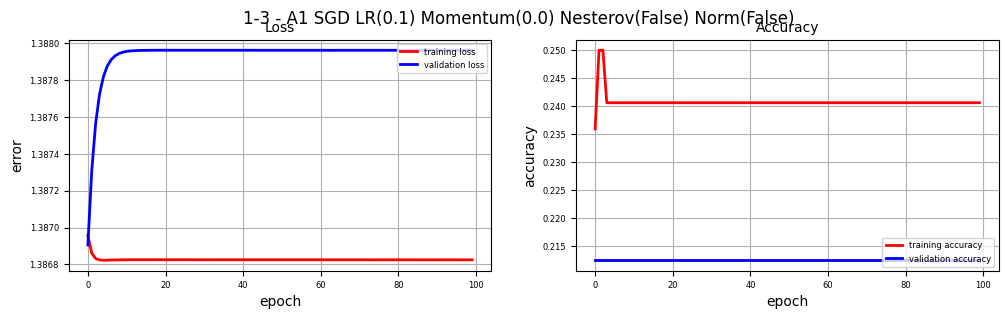

1-3 - A1 SGD LR(0.1) Momentum(0.0) Nesterov(False) Norm(False)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.26      1.00      0.41        51
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57

    accuracy                           0.26       200
   macro avg       0.06      0.25      0.10       200
weighted avg       0.07      0.26      0.10       200

confusion matrix
[[ 0 44  0  0]
 [ 0 51  0  0]
 [ 0 48  0  0]
 [ 0 57  0  0]]
Accuracy score: 25.5


2025-03-12 07:49:08.014856: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
/home/sam/howest/howest-dl/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

In [17]:
deel_1_variatie_learning_rate(experiment = "1-3", learning_rate = 0.1, momentum = 0.0, nesterov = False, batch_normalization = False)

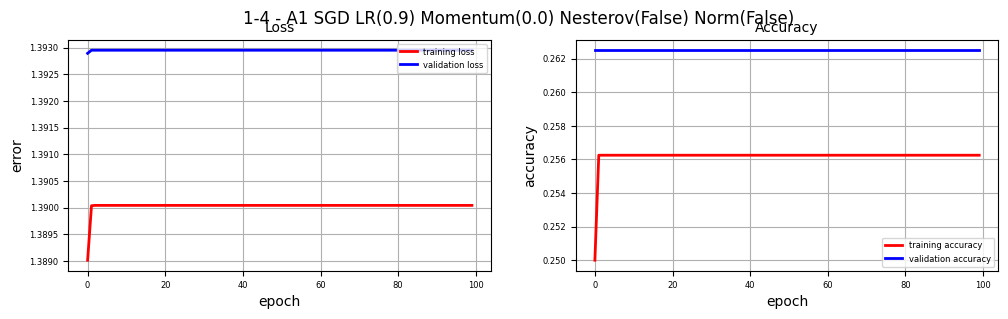

1-4 - A1 SGD LR(0.9) Momentum(0.0) Nesterov(False) Norm(False)


2025-03-12 07:49:22.606180: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.00      0.00      0.00        51
           2       0.24      1.00      0.39        48
           3       0.00      0.00      0.00        57

    accuracy                           0.24       200
   macro avg       0.06      0.25      0.10       200
weighted avg       0.06      0.24      0.09       200

confusion matrix
[[ 0  0 44  0]
 [ 0  0 51  0]
 [ 0  0 48  0]
 [ 0  0 57  0]]
Accuracy score: 24.0


/home/sam/howest/howest-dl/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sam/howest/howest-dl/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sam/howest/howest-dl/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [18]:
deel_1_variatie_learning_rate(experiment = "1-4", learning_rate = 0.9, momentum = 0.0, nesterov = False, batch_normalization = False)

## 2. Verschillende optimizers

In [19]:
def deel_2_variatie_optimizers(
    experiment,
    optimizer,
):
    """ De functie maakt gebruik van de globale X, y, X_test, y_test waarden """
    experiment_name = f"{experiment}"
    nn_model = nn_architecture_1(
        # NN layout parameters
        name = experiment_name,
        input_dimension = X_train.shape[1],
        output_dimension = y_train.shape[1],
        number_of_hidden_layers = 4,
        hidden_layer_neurons = 20,
        dropoutrate = 0.0,
        activation_function_hidden_layer = "relu",
        activation_function_output_layer = "sigmoid",
        kernel_initializer = "RandomUniform",
        optimizer=optimizer,
        batch_normalization = True,
    )
    
    # train the model
    history = nn_model.fit(
        X_train, y_train,
        epochs=100,
        validation_split = 0.2,  # use 20% of the training data used for validation
        verbose=1
    )
    
    # Display Results
    plot_history(history.history, title=experiment_name)
    print_metrics(nn_model, X_test, y_test, title=experiment_name)
    # plot_decision_boundary(nn_model, X, y, title=experiment_name) 

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5903 - loss: 1.2693 - val_accuracy: 0.2812 - val_loss: 1.3861
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8636 - loss: 0.9604 - val_accuracy: 0.2812 - val_loss: 1.3859
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8527 - loss: 0.7461 - val_accuracy: 0.2812 - val_loss: 1.3857
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8760 - loss: 0.5952 - val_accuracy: 0.2812 - val_loss: 1.3851
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8728 - loss: 0.5022 - val_accuracy: 0.2812 - val_loss: 1.3841
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8806 - loss: 0.4383 - val_accuracy: 0.2812 - val_loss: 1.3832
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8887 - loss: 0.3976 - val_accuracy: 0.2812 - val_loss: 1.3818
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8870 - loss: 0.3656 - val_accuracy: 0.

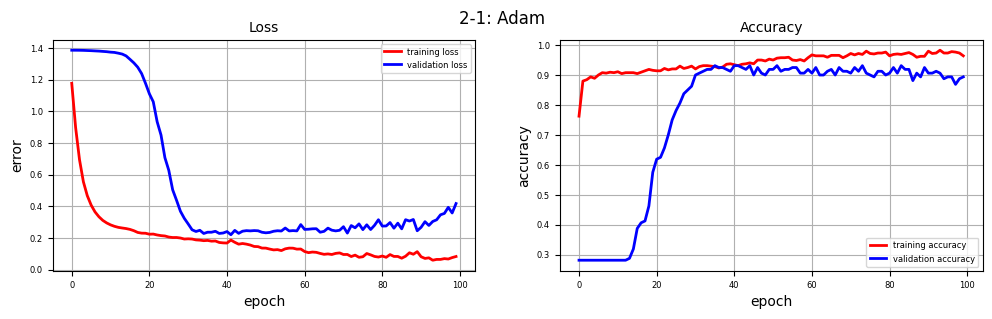

2-1: Adam
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
classification report
              precision    recall  f1-score   support

           0       0.83      0.68      0.75        44
           1       0.94      0.98      0.96        51
           2       0.90      0.90      0.90        48
           3       0.89      0.98      0.93        57

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.90      0.89       200

confusion matrix
[[30  3  5  6]
 [ 1 50  0  0]
 [ 4  0 43  1]
 [ 1  0  0 56]]
Accuracy score: 89.5


2025-03-12 07:51:05.325470: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


In [20]:
deel_2_variatie_optimizers(experiment = "2-1: Adam LR=0.001", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
deel_2_variatie_optimizers(experiment = "2-2: Adam LR=0.01", optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [ ]:
deel_2_variatie_optimizers(experiment = "2-3: Adam LR=0.1", optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

## Customer satisfaction

Een bank probeert vroegtijdig ontevreden klanten op te sporen en wil daarvoor deep learning toepassen.
Gegeven is een dataset "customersatisfaction.csv" met geanonimiseerde gegevens van hun klanten en de bijhorende klantentevredenheid. De features zelf werden ook geanonimiseerd.
De target kolom is de variabele die voorspeld moet worden. 1 staat voor ontevreden klanten, 0 staat voor tevreden klanten.

Train een neuraal netwerk dat een zo hoog mogelijke accuraatheid haalt. 
Zorg dat er 10000 samples in de test set aanwezig zijn en zet de random_state op 0.

In [ ]:
dataset = pd.read_csv('./customersatisfaction.csv')

dataset.head(10)

In [ ]:
# Uitwerking opdracht customer satisfaction



## Zalando 

Fashion-MNIST is een dataset van Zalando bestaande uit afbeeldingen van kledij. De training set ('fashion-mnist_train.csv') bestaat uit 60000 afbeeldingen, de test set ('fashion-mnist_test.csv') uit 10000 afbeeldingen.
Elke grijsafbeelding is 28x28 pixels groot en is toegewezen aan één van de 10 klasses: 

0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'.

Train een neuraal netwerk dat een zo hoog mogelijke accuracy score behaalt op de test set.
Eén optie is om als features de ruwe pixeldata (784 pixels) te gebruiken. Een andere benadering is om via Principle Component Analysis (PCA) de featureset te reduceren en daarmee als het ware feature extraction toe te passen.
Onderzoek welke afbeeldingen niet correct werden geclassificeerd en visualiseer ze.

Tijdens de volgende sessie zullen we op dezelfde dataset convolutional neural networks toepassen. Deze neurale netwerk architectuur leent zich uitstekend voor image classification.

Vergelijk jouw eigen accuracy score met deze opgelijst op https://github.com/zalandoresearch/fashion-mnist.


In [ ]:
df_train = pd.read_csv('./fashion-mnist_train.csv')
df_test = pd.read_csv('./fashion-mnist_test.csv')
df_train.head()

In [ ]:
# Uitwerking Zalando oefening

